In [1]:
import sys
import json

import torch

import torch.nn.functional as F

In [2]:
SRC_PATH = './src'
if SRC_PATH not in sys.path:
    sys.path.insert(-1, SRC_PATH)
    print(sys.path)
    
from models import CifarResNet50
from resnet import ResNet50
from utils import *
from data_factory import *
from main import *


['/home/xuanyu/tmp/tmp_dir/GAN', '/home/xuanyu/anaconda3/envs/debatestar/lib/python37.zip', '/home/xuanyu/anaconda3/envs/debatestar/lib/python3.7', '/home/xuanyu/anaconda3/envs/debatestar/lib/python3.7/lib-dynload', '', '/home/xuanyu/anaconda3/envs/debatestar/lib/python3.7/site-packages', '/home/xuanyu/anaconda3/envs/debatestar/lib/python3.7/site-packages/IPython/extensions', './src', '/home/xuanyu/.ipython']


In [3]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

In [4]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def null_attack(image, epsilon, data_grad):
    return image

def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()


def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()



In [5]:
# Initialize the network
with open('./config/experiment.json', 'r') as fh:
    config = json.load(fh)
device_use = load_device(config['experiment']['cuda'])

model = ResNet50()
ckpt = torch.load('./checkpoint/ckpt%s.pth'%config['experiment']['EXPERIMENT_IDX'])
model.load_state_dict(ckpt['model'])
model.to(device_use)
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval();

cuda:4


In [6]:
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

test_set = datasets.CIFAR10(root='./data', train=False, download=False, transform=normalize)
test_dataloader = DataLoader(test_set, batch_size = 1, shuffle=False, num_workers=0)



In [9]:
def test(model, device, test_loader, eps):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
#         init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        _, init_pred = output.max(1)
#         init_pred = torch.squeeze(init_pred.view(1, -1), 0)
        # If the initial prediction is wrong, dont bother attacking, just move on
        if not init_pred.eq(target).item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()
        
        delta = pgd_linf_targ(model, data, target, epsilon=eps, alpha=1e-2, num_iter=10, y_targ=2)
        perturbed_data = torch.sum(data + delta, dim = 0, keepdim = True)
#         plot_images(X+delta, y, perturbed_data, 3, 6)


#         # Collect datagrad
#         data_grad = data.grad.data

#         # Call FGSM Attack
#         perturbed_data = fgsm_attack(data, epsilon, data_grad)
# #         perturbed_data = null_attack(data, epsilon, data_grad)
    
        # Re-classify the perturbed image

        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (eps == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [10]:
accuracies = []
examples = []
epsilons = [.05, .1, .15, .2, .25, .3, .4, .6, .8, .99]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device_use, test_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.05	Test Accuracy = 2185 / 10000 = 0.2185
Epsilon: 0.1	Test Accuracy = 1299 / 10000 = 0.1299
Epsilon: 0.15	Test Accuracy = 1299 / 10000 = 0.1299
Epsilon: 0.2	Test Accuracy = 1299 / 10000 = 0.1299
Epsilon: 0.25	Test Accuracy = 1299 / 10000 = 0.1299
Epsilon: 0.3	Test Accuracy = 1299 / 10000 = 0.1299
Epsilon: 0.4	Test Accuracy = 1299 / 10000 = 0.1299
Epsilon: 0.6	Test Accuracy = 1299 / 10000 = 0.1299
Epsilon: 0.8	Test Accuracy = 1299 / 10000 = 0.1299
Epsilon: 0.99	Test Accuracy = 1299 / 10000 = 0.1299


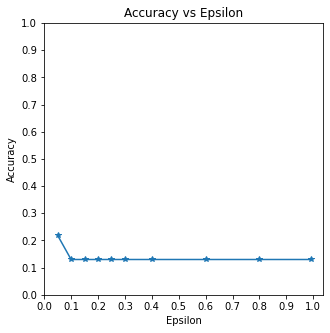

In [11]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [12]:
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())


In [13]:
vals = [c.decode('UTF-8') for c in unpickle('./data/cifar-10-batches-py/batches.meta')[b'label_names']]
count = 0
class_mapping = {}
for v in vals:
    class_mapping[count] = v
    count += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

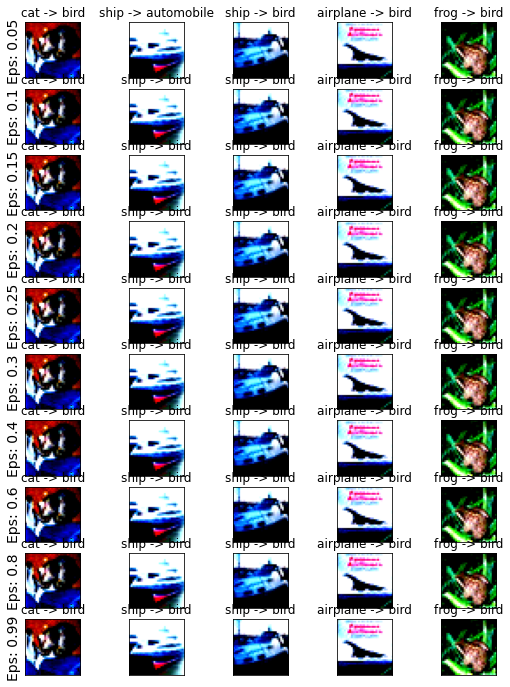

In [14]:
cnt = 0
plt.figure(figsize=(9,12))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
#         print(orig, adv, class_mapping)
        plt.title("{} -> {}".format(class_mapping[orig], class_mapping[adv]))
#         norm_ex = unnormalize(torch.tensor(ex)).numpy()
        plt.imshow(np.rollaxis(ex, 0, 3))



In [15]:

plt.savefig('./demo_img.png')
plt.show()

<Figure size 432x288 with 0 Axes>